# This is a simple example of a pipeline for verification GB 

In [1]:
### Importing needed packages
import numpy as np
import sys, os
import time

from LISAhdf5 import LISAhdf5,ParsUnits
import tdi

import FastGB as FB

import NUTS_MCMC as nuts

import VGB_aux 

import matplotlib.pyplot as plt
import matplotlib as mpl


/Users/stas/anaconda2/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [7]:
### Auxiliary Functions
def logProbX(data, pars):
    #{{{

    pp = pars[0]
    Df = data

    l_Amp = pp[0]
    mf0 = pp[1]
    l_fdot = pp[2]
    sin_bet = pp[3]
    lam = pp[4]
    cos_iota = pp[5]
    psi = pp[6]
    phi0 = pp[7]

    inPrior = True

    if (l_Amp < Amp_bnd[0] or l_Amp > Amp_bnd[1]):
        inPrior = False
        print ("amp")
    if (mf0 < fr_bnd[0] or mf0 > fr_bnd[1]):
        inPrior = False
        print ("fr")
    if (l_fdot < fdot_bnd[0] or l_fdot > fdot_bnd[1]):
        inPrior = False
        print ("fd")
    if (sin_bet < sin_bet_bnd[0] or sin_bet > sin_bet_bnd[1]):
        inPrior = False
        print ("bt")
    if (lam < lam_bnd[0] or lam > lam_bnd[1]):
        inPrior = False
        print ("lm")
    if (cos_iota < cos_iota_bnd[0] or cos_iota>cos_iota_bnd[1]):
        inPrior = False
        print ("io")
    if (psi < psi_bnd[0] or psi > psi_bnd[1]):
        inPrior = False
        print ("psi")
    if (phi0 < phi0_bnd[0] or phi0 > phi0_bnd[1]):
        inPrior = False
        print ("ph")

    if (not inPrior):
        return (-np.inf)
    else:
        #### generate the waveform
        iota = np.arccos(cos_iota)
        beta = np.arcsin(sin_bet)
        Amp = 10.0**l_Amp
        f0 = mf0 *1.e-3
        fdot = 10.0**l_fdot
        # fdot = l_fdot

        prm = np.array([f0, fdot, beta, lam, Amp, iota, psi, phi0])
        print ("wvf:", prm)
        Xf, Yf, Zf = fastGB.onefourier(simulator='synthlisa', params=prm, buffer=None, T=Tobs, dt=del_t, algorithm='Michele', oversample=4)

        Xf = Xf/df
        fr = np.arange(Xf.kmin,Xf.kmin+len(Xf))*df
        ib = Xf.kmin
        ie = Xf.kmin+len(Xf)

        Sn = tdi.noisepsd_X(f0, model='Proposal', includewd=None)

        SNR2 = np.sum( np.real(Df[ib:ie] * np.conjugate(Xf)) )
        hh = np.sum(np.absolute(Xf)**2)

        loglik = 4.0*df*( SNR2 - 0.5 * hh )/Sn

        return (loglik) ### we ignore many normalization factors

    #}}}

def gradlikX(data, pars):

    Df = data
    pp = pars[0]

    l_Amp = pp[0]
    mf0 = pp[1]
    l_fdot = pp[2]
    sin_bet = pp[3]
    lam = pp[4]
    cos_iota = pp[5]
    psi = pp[6]
    phi0 = pp[7]

    grad = np.zeros(len(pp))

    inPrior = True

    if (l_Amp < Amp_bnd[0] or l_Amp > Amp_bnd[1]):
        inPrior = False
        print ("amp")
    if (mf0 < fr_bnd[0] or mf0 > fr_bnd[1]):
        inPrior = False
        print ("fr", mf0, fr_bnd)
    if (l_fdot < fdot_bnd[0] or l_fdot > fdot_bnd[1]):
        inPrior = False
        print ("fd")
    if (sin_bet < sin_bet_bnd[0] or sin_bet > sin_bet_bnd[1]):
        inPrior = False
        print ("bt")
    if (lam < lam_bnd[0] or lam > lam_bnd[1]):
        inPrior = False
        print ("lm")
    if (cos_iota < cos_iota_bnd[0] or cos_iota>cos_iota_bnd[1]):
        inPrior = False
        print ("io")
    if (psi < psi_bnd[0] or psi > psi_bnd[1]):
        inPrior = False
        print ("psi")
    if (phi0 < phi0_bnd[0] or phi0 > phi0_bnd[1]):
        inPrior = False
        print ("ph")

    if (not inPrior):
        return (grad)
    else:

        Amp = 10.0**l_Amp
        iota = np.arccos(cos_iota)
        beta = np.arcsin(sin_bet)
        f0 = mf0*1.e-3
        fdot = 10.0**l_fdot
        # fdot = l_fdot

        prm = np.array([f0, fdot, beta, lam, Amp, iota, psi, phi0])
        Xf, Yf, Zf = fastGB.onefourier(simulator='synthlisa', params=prm, buffer=None, T=Tobs, dt=del_t, algorithm='Michele', oversample=4)

        Xf = Xf/df
        fr = np.arange(Xf.kmin,Xf.kmin+len(Xf))*df
        ib = Xf.kmin
        ie = Xf.kmin+len(Xf)

        Sn = tdi.noisepsd_X(f0, model='Proposal', includewd=None)


        ### Amplitude:

        SNR2 = np.sum( np.real(Df[ib:ie] * np.conjugate(Xf)) )
        hh = np.sum(np.absolute(Xf)**2)
        grad[0] = 2.302585092994046 * 4.0*df*( (SNR2 - hh) )/Sn ### first factor is 1/log10(e)


        ### freq

        dl = 5.e-6
        f0_m = (1.0+dl)*f0
        dp = dl*f0
        prm_m = np.array([f0_m, fdot, beta, lam, Amp, iota, psi, phi0])
        Xfm, Yfm, Zfm = fastGB.onefourier(simulator='synthlisa', params=prm_m, buffer=None, T=Tobs, dt=del_t, algorithm='Michele', oversample=4)
        Xfm = Xfm/df

        dXf = (Xfm - Xf)/dp
        ib = dXf.kmin
        ie = len(dXf) + dXf.kmin
        DdX = np.sum( np.real(Df[ib:ie] * np.conjugate(dXf)) )
        dXX = np.sum( np.real(Xf * np.conjugate(dXf)) )
        grad[1] = 1.e-3* 4.0*df*(DdX - dXX)/Sn  ### factor from mHz
        

        ### freq_dot

        dl = 1.e-3
        fdot_m = (1.0+dl)*fdot
        dp = dl*fdot
        prm_m = np.array([f0, fdot_m, beta, lam, Amp, iota, psi, phi0])
        Xfm, Yfm, Zfm = fastGB.onefourier(simulator='synthlisa', params=prm_m, buffer=None, T=Tobs, dt=del_t, algorithm='Michele', oversample=4)
        Xfm = Xfm/df

        dXf = (Xfm - Xf)/dp
        ib = dXf.kmin
        ie = len(dXf) + dXf.kmin
        DdX = np.sum( np.real(Df[ib:ie] * np.conjugate(dXf)) )
        dXX = np.sum( np.real(Xf * np.conjugate(dXf)) )
        grad[2] =  2.302585092994046 * fdot* 4.0*df*(DdX - dXX)/Sn ### Assuming log10(fdot)


        ### sin bet
        dl = 1.e-3
        if (beta == 0.5*np.pi):
            dl = -1.e-3
        beta_m = (1.0+dl)*beta
        dp = dl*beta
        prm_m = np.array([f0, fdot, beta_m, lam, Amp, iota, psi, phi0])
        Xfm, Yfm, Zfm = fastGB.onefourier(simulator='synthlisa', params=prm_m, buffer=None, T=Tobs, dt=del_t, algorithm='Michele', oversample=4)
        Xfm = Xfm/df

        dXf = (Xfm - Xf)/dp
        ib = dXf.kmin
        ie = len(dXf) + dXf.kmin
        DdX = np.sum( np.real(Df[ib:ie] * np.conjugate(dXf)) )
        dXX = np.sum( np.real(Xf * np.conjugate(dXf)) )
        grad[3] = 4.0*df*(DdX - dXX)/Sn

        eps = 1.e-3
        cb = np.cos(beta)
        if (beta == 0.5*np.pi or beta == -0.5*np.pi):
            cb = eps

        grad[3] = grad[3]/cb  ## we use sin(beta) as parameter

        ### lam

        dl = 1.e-3
        lam_m = (1.0+dl)*lam
        dp = dl*lam
        prm_m = np.array([f0, fdot, beta, lam_m, Amp, iota, psi, phi0])
        Xfm, Yfm, Zfm = fastGB.onefourier(simulator='synthlisa', params=prm_m, buffer=None, T=Tobs, dt=del_t, algorithm='Michele', oversample=4)
        Xfm = Xfm/df

        dXf = (Xfm - Xf)/dp
        ib = dXf.kmin
        ie = len(dXf) + dXf.kmin
        DdX = np.sum( np.real(Df[ib:ie] * np.conjugate(dXf)) )
        dXX = np.sum( np.real(Xf * np.conjugate(dXf)) )
        grad[4] = 4.0*df*(DdX - dXX)/Sn


        ### cos(iota)

        dl = 1.e-3
        if (iota == np.pi):
         dl = -1.e-3
        iota_m = (1.0+dl)*iota
        dp = dl*iota
        prm_m = np.array([f0, fdot, beta, lam, Amp, iota_m, psi, phi0])
        Xfm, Yfm, Zfm = fastGB.onefourier(simulator='synthlisa', params=prm_m, buffer=None, T=Tobs, dt=del_t, algorithm='Michele', oversample=4)
        Xfm = Xfm/df

        dXf = (Xfm - Xf)/dp
        ib = dXf.kmin
        ie = len(dXf) + dXf.kmin
        DdX = np.sum( np.real(Df[ib:ie] * np.conjugate(dXf)) )
        dXX = np.sum( np.real(Xf * np.conjugate(dXf)) )
        grad[5] = 4.0*df*(DdX - dXX)/Sn

        eps = 1.e-3
        sb = -np.sin(iota)
        if (iota == 0.0 or iota == np.pi):
            sb = -eps

        grad[5] = grad[5]/sb  ## we use cos(iota) as parameter
    

        ### psi

        dl = 1.e-3
        psi_m = (1.0+dl)*psi
        dp = dl*psi
        prm_m = np.array([f0, fdot, beta, lam, Amp, iota, psi_m, phi0])
        Xfm, Yfm, Zfm = fastGB.onefourier(simulator='synthlisa', params=prm_m, buffer=None, T=Tobs, dt=del_t, algorithm='Michele', oversample=4)
        Xfm = Xfm/df


        dXf = (Xfm - Xf)/dp
        ib = dXf.kmin
        ie = len(dXf) + dXf.kmin
        DdX = np.sum( np.real(Df[ib:ie] * np.conjugate(dXf)) )
        dXX = np.sum( np.real(Xf * np.conjugate(dXf)) )
        grad[6] = 4.0*df*(DdX - dXX)/Sn


        ### Check analytically
        prm_m = np.array([f0, fdot, beta, lam, Amp, iota, psi, phi0+0.5*np.pi])
        Xfm, Yfm, Zfm = fastGB.onefourier(simulator='synthlisa', params=prm_m, buffer=None, T=Tobs, dt=del_t, algorithm='Michele', oversample=4)
        Xfm = Xfm/df

        dXf = Xfm
        ib = dXf.kmin
        ie = len(dXf) + dXf.kmin
        DdX = np.sum( np.real(Df[ib:ie] * np.conjugate(dXf)) )
        dXX = np.sum( np.real(Xf * np.conjugate(dXf)) )
        grad[7] = 4.0*df*(DdX - dXX)/Sn


        return(grad)


def Fstat(fr_i, bet_i, lam_i, Tobs, fdot=1.e-17):
    df = 1.0/Tobs

    amp = 1.e-21
    lAmp = np.log10(amp)
    prm1 = np.array([fr_i*1.e-3, fdot, bet_i, lam_i, amp, 0.5*np.pi, 0.0, 0.0])

    Xf1, Yf1, Zf1 = fastGB.onefourier(simulator='synthlisa', params=prm1, buffer=None, T=Tobs, dt=del_t, algorithm='Michele', oversample=4)
    Xf1 = Xf1/df

   
    prm2  = np.array([fr_i*1.e-3, fdot, bet_i, lam_i, amp, 0.5*np.pi, 0.25*np.pi, 0.0])
    Xf2, Yf2, Zf2 = fastGB.onefourier(simulator='synthlisa', params=prm2, buffer=None, T=Tobs, dt=del_t, algorithm='Michele', oversample=4)
    Xf2 = Xf2/df


    Sn = tdi.noisepsd_X(fr_i*1.e-3, model='Proposal', includewd=None)

    U = np.sum(np.absolute(Xf1)**2)
    V = np.sum(np.absolute(Xf2)**2)
    W = np.sum(Xf1*np.conjugate(Xf2))
    # print ("SBtest", U, V, W)

    ib = Xf1.kmin
    ie = Xf1.kmin+len(Xf1)

    Nu = np.sum( Df[ib:ie] * np.conjugate(Xf1) )
    Nv = np.sum( Df[ib:ie] * np.conjugate(Xf2) )

    Del = U*V - np.absolute(W)**2

    Fstat = 2.0*df*( V*np.absolute(Nu)**2 + U*np.absolute(Nv)**2 - 2.0*np.real(W*Nu*np.conjugate(Nv)) )/(Del*Sn)

    a1c = (V*Nu - np.conjugate(W)*Nv)/Del
    a2c = (U*Nv - W*Nu)/Del


    ### reconstruct the signal
    a1 = np.real(a1c)
    a3 = np.imag(a1c)
    a2 = np.real(a2c)
    a4 = np.imag(a2c)

    A = a1**2 + a2**2 + a3**2 + a4**2
    D = a1*a4 - a2*a3

    Ap = 0.5*(np.sqrt(A + 2.0*D) + np.sqrt(A - 2.0*D))
    Ac = 0.5*(np.sqrt(A - 2.0*D) - np.sqrt(A + 2.0*D))


    Amp = 0.5*(Ap + np.sqrt(Ap*Ap - Ac*Ac))
    cos_i = 0.5*Ac/Amp
    phi0 = 0.5*np.arctan2(2.0*(a1*a3 + a2*a4), (a1*a1 + a2*a2 - a3*a3 -a4*a4))
    psi = 0.25*np.arctan2(2.0*(a1*a2 + a3*a4), (a1*a1 + a3*a3 - a2*a2 -a4*a4))
    psi = psi - np.pi
    phi0 = phi0 - np.pi
    if (psi < 0. ):
        psi += 2.*np.pi
    if (phi0 < 0. ):
        phi0 += 2.*np.pi

    l_Amp = np.log10(Amp) + lAmp


    return ([Fstat, l_Amp, fr_i, fdot, bet_i, lam_i, cos_i, psi, phi0])


### Reading hdf5 data file

In [3]:
FD5 =  LISAhdf5("../VGB/Data/LDC1-3_VGB_v1.hdf5")
# FD5 =  LISAhdf5("../VGB/Data/LDC1-3_VGB_v1_FD_noiseless.hdf5")
Nsrc = FD5.getSourcesNum()
GWs = FD5.getSourcesName()
print ("Found %d GW sources: " % Nsrc, GWs)
### TODO make sure GalBin is there
if (GWs[0] != 'GalBinaries'):
    raise NotImplementedError
p = FD5.getSourceParameters(GWs[0])
td = FD5.getPreProcessTDI()
del_t = float(p.get("Cadence"))
Tobs = float(p.get("ObservationDuration"))

p.display()

### FFT-ing the data (using only X-TDI)
df = 1.0/Tobs
XDt = td[:, 1]
tm = td[:, 0]
win = VGB_aux.Window(tm)

Df = np.fft.fft(XDt)
freqD = np.fft.fftfreq(len(tm), del_t)
Nfd = len(freqD)
Nfd = int(Nfd/2)
freqD = freqD[:Nfd]   ### using only positive freqs
Df = Df[:Nfd] *del_t  ### normalizing FFT

seed = 0
np.random.seed(seed)

Found 1 GW sources:  ['GalBinaries']
	Amplitude [1.07345e-22 1.36368e-22 1.76276e-22 7.34608e-23 1.50933e-22 5.35906e-23
 3.29570e-23 7.39547e-23 6.37823e-23 1.66997e-22] [strain]
	Cadence 15.0 [Seconds]
	EclipticLatitude [ 0.312414  -0.529009   0.0865683  0.490263   0.653451  -0.354825
  0.816989   0.490263  -0.082205   0.101404 ] [Radian]
	EclipticLongitude [-2.75291 -2.51031 -2.18009  2.28603  2.97387  0.4297  -1.13534  2.28603
  2.10225  1.76872] [Radian]
	Frequency [0.00135962 0.00125313 0.00181324 0.00166667 0.00194414 0.00322061
 0.0035125  0.0016835  0.00622028 0.00261301] [Hz]
	FrequencyDerivative [8.94581279e-19 9.15958730e-19 2.04973995e-18 2.18905890e-18
 6.48972578e-18 1.74586691e-17 2.78570006e-17 2.27120824e-18
 7.48528554e-16 2.90562842e-17] [Hz^2]
	Inclination [0.523599   0.244346   0.523599   1.22173    0.750492   1.6169347
 1.5063286  1.67948105 0.645772   1.51669   ] [Radian]
	InitialPhase [3.0581565  2.64414439 2.97459105 3.2219877  3.00689165 2.84090075
 3.1855139

### Set the boundaries for parameters

In [4]:
Amp_bnd = [-24.0, -20.0] ### log10 amplitude
fr_bnd = [1.0, 2.0]   ###  frequency in mHz
fdot_bnd = [-19.0, -15.0]  ### log10(fdot)
sin_bet_bnd = [-1.0, 1.0]  ### sin(ecliptic latitude)
lam_bnd = [-np.pi, np.pi]  ### ecliptic longitude
cos_iota_bnd = [-1.0, 1.0] ### cos(inclination)
psi_bnd = [0.0, 2.0*np.pi] ### polarization
phi0_bnd = [0.0, 2.0*np.pi] ### initial phase

### Let's check if everything (likelihood, etc) works

In [8]:
fastGB = FB.FastGB("Test", dt=del_t, Tobs=Tobs, orbit="analytic")


Nsrc = len(p.get('Frequency'))
for ind in range(Nsrc):
    print ("source ind = ", ind)
    bet, lam, Amp, f0, fdot, iota, psi, phi0 = VGB_aux.GetParams(p, ind)
    prm = np.array([f0, fdot, bet, lam, Amp, iota, psi, phi0])
    ### remapping
    sin_b = np.sin(bet)
    cos_i = np.cos(iota)
    l_Amp = np.log10(Amp)
    l_fdot = np.log10(fdot)
    
    loglik = logProbX(Df, [[l_Amp, f0*1.e3, l_fdot, sin_b, lam, cos_i, psi, phi0]])
    print ("loglik:", loglik, np.sqrt(2.0*loglik))
    
    print ("Fstat:", Fstat(f0*1.e3, bet, lam, Tobs, fdot))
    
    gradlik = gradlikX(Df, [[l_Amp, f0*1.e3, l_fdot, sin_b, lam, cos_i, psi, phi0]])
    print ("grad log lik:", gradlik)
    
    

source ind =  0
wvf: [ 1.35962000e-03  8.94581279e-19  3.12414000e-01 -2.75291000e+00
  1.07345000e-22  5.23599000e-01  3.56216560e+00  3.05815650e+00]
loglik: 301.6965262711249 24.5640601803173
Fstat: [303.92918325515103, -21.804612715960022, 1.35962, 8.945812789786104e-19, 0.312414, -2.75291, 0.5849205806941747, 2.6966661843435515, 1.6407101720788422]
grad log lik: [ 5.74297464e+01 -1.17071572e+06 -1.78250934e-01 -7.73194169e+00
 -1.09069976e+02  2.97998107e+01 -1.55180824e+01 -7.81822644e+00]
source ind =  1
wvf: [ 1.25313000e-03  9.15958730e-19 -5.29009000e-01 -2.51031000e+00
  1.36368000e-22  2.44346000e-01  2.22942636e+00  2.64414439e+00]
loglik: 384.9141467015307 27.74577974040487
Fstat: [386.8632087621638, -21.713472038018754, 1.25313, 9.159587298288947e-19, -0.529009, -2.51031, 0.6337526455955916, 3.1396280864809087, 4.019878327993704]
grad log lik: [-3.37195143e+01  4.01357181e+06  5.74122393e-01 -8.08395705e+01
  9.95067705e+01 -1.44104693e+01  7.51338202e+01  3.75386906e+01

/Users/stas/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in sqrt
  app.launch_new_instance()


## Step 1. Compute F-statistic (likelihood maximized analytically over some extrinsic parameters) on a simple uniform grid

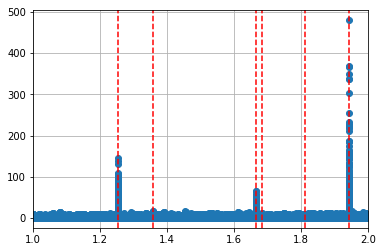

In [10]:
# Nfr = 1000
# frs = np.linspace(fr_bnd[0], fr_bnd[1], Nfr)
# print ("df = ", frs[1]-frs[0])
# Nbet = 10
# Nlam = 20
#
# Ntot = Nfr*Nbet*Nlam
# print ("grid_size:", Nfr, Nbet, Nlam)
# print (Ntot, "evaluations")
#
# bets = np.linspace(-0.5*np.pi, 0.5*np.pi, Nbet)
# lams = np.linspace(lam_bnd[0], lam_bnd[1], Nlam)
#
#
# st = time.time()
# ci = 0
# fout = open("Fstat.dat", 'w')
# for fi in range(Nfr):
#     for bi in range(Nbet):
#         for li in range(Nlam):
#             Fpar = Fstat(frs[fi], bets[bi], lams[li])
#             rec = ""
#             for ii in range(len(Fpar)):
#                 rec = rec + str(Fpar[ii]) + "   "
#             rec = rec + " \n"
#             fout.write(rec)
#             ci += 1
#             # sys.exit(0)
# fout.close()
# en = time.time()
#
# print ("ellapsed", en-st)
#
# print (20*"-----")
# sys.exit(0)

# reading Fstat file

dat = np.genfromtxt("Fstat.dat")
fr_tr = [0.00135962, 0.00125313, 0.00181324, 0.00166667, 0.00194414, 0.00322061, 0.0035125, 0.0016835, 0.00622028, 0.00261301]

Fstat = dat[:, 0]
fr_i = dat[:, 2]

### Plot the results and compare to the true frequencies:
plt.plot(fr_i, Fstat, 'o')
for fr in fr_tr:
    plt.axvline(x=fr*1.e3, color='r', linestyle='--')
plt.grid(True)
plt.xlim([1., 2.])
plt.show()


* Clustering the results of F-stat in freq. space and choosing candidates with Fstat > 15.0

In [11]:
### clustering the candidates, using threshold 15.0
ind_t = np.argwhere(Fstat > 15.0)
fr_cand = np.unique(fr_i[ind_t])

src_cand = {}
for i in range(len(fr_cand)):
    fr_c = fr_cand[i]
    Fst_max = 0.0
    i_m = 0
    for ii in ind_t:
        if (fr_i[ii] == fr_c):
            if (Fstat[ii] > Fst_max):
                i_m = ii
                Fst_max = Fstat[ii]
    src_cand[i] = dat[i_m]

print ("Candidates \n", src_cand)

ind_ch = 0
print ("Chosen candidate:", src_cand[ind_ch])

Candidates 
 {0: array([[ 1.45754321e+02, -2.15685225e+01,  1.25325325e+00,
         1.00000000e-17, -8.72664626e-01,  1.48812284e+00,
         1.09481801e-02,  2.75864783e+00,  1.87388710e+00]]), 1: array([[ 1.62431358e+01, -2.21328561e+01,  1.35935936e+00,
         1.00000000e-17, -5.23598776e-01,  1.48812284e+00,
         1.40225934e-01,  3.12200937e+00,  3.99182681e+00]]), 2: array([[ 1.57773951e+01, -2.22281344e+01,  1.45345345e+00,
         1.00000000e-17,  5.23598776e-01,  2.48020473e+00,
        -7.04433021e-02,  3.67622186e+00,  4.36798404e+00]]), 3: array([[ 1.54922662e+01, -2.23629301e+01,  1.61161161e+00,
         1.00000000e-17,  8.72664626e-01,  2.14951076e+00,
        -2.74317961e-01,  2.77959224e+00,  2.43965463e+00]]), 4: array([[ 6.52994431e+01, -2.22691319e+01,  1.66666667e+00,
         1.00000000e-17,  5.23598776e-01,  2.48020473e+00,
         4.96656755e-01,  2.46025333e+00,  1.77807860e+00]]), 5: array([[ 4.79912995e+02, -2.17340533e+01,  1.94394394e+00,
         

## Step 2. Running Hamiltonian Markov Chain Monte Carlo (No-U-Turn-Sampler=NUTS) starting from a candidate

In [13]:
### seeding the chain at the F-stat candidate
pr = src_cand[ind_ch][0][1:]
pr[3] = np.sin(pr[3])
pr[2] = np.log10(pr[2])
th = np.copy(pr) 
nDim = len(th)


### Setting parameters

eps = 1.e-2 ### step of Hamiltonian integration
Niter = 300  ### number of points in the chain
samples = np.zeros((Niter, nDim))
LogLik = np.zeros(Niter)

### introduce not unit mass:
iMass = np.ones(nDim)
iMass[1] = 5.e-5 ### modify mass for the freq
iMass[2] = 3.0   ###modify mass for freq. derivative

VGB = nuts.NUTS(Df, 10., logProbX, gradlikX)




print ("Starting main loop")
for itr in range(Niter):
    print ("   ")
    print("iter", itr)
    C, j, alph_aver = VGB.OneIterationSimple(th, eps, iMass)
    Nc = len(C)
    ll_h = np.zeros(Nc)
    for i, th in enumerate(C):
        ll_h[i] = VGB.ComputeLogProb(th)
        print (th, ll_h[i])
    ind = 0
    if (Nc >1):
        ind = np.random.randint(0, Nc)
    th = C[ind]
#     print ("chosen", ind, th, eps, alph_aver)
    samples[itr, :] = np.copy(th)
    LogLik[itr] = ll_h[ind]






Starting main loop
   
iter 0
8 3.141592653589793
wvf: [ 1.25325325e-03  1.00000000e-17 -8.72664626e-01  1.48812284e+00
  2.70070728e-22  1.55984793e+00  2.75864783e+00  1.87388710e+00]
th=  [-2.15685225e+01  1.25325325e+00 -1.70000000e+01 -7.66044443e-01
  1.48812284e+00  1.09481801e-02  2.75864783e+00  1.87388710e+00] logp0 =  145.75432112411494 gradp0 =  [ 2.76551593e-12  2.64517205e+06  7.07759146e+00 -7.98896427e+01
  1.92987425e+00 -7.09908689e-10  2.65887246e-11 -6.56740449e-10]
r0 =  [ 1.76405235e+00  2.00078604e-05  2.93621395e+00  2.24089320e+00
  1.86755799e+00 -9.77277880e-01  9.50088418e-01 -1.51357208e-01]
join0 =  134.6926924789086
logu =  131.3777802968548 134.6926924789086
negative dir
wvf: [ 1.25325325e-03  1.00000000e-17 -8.72664626e-01  1.48812284e+00
  2.70070728e-22  1.55984793e+00  2.75864783e+00  1.87388710e+00]
LF, gradp =  [ 2.76551593e-12  2.64517205e+06  7.07759146e+00 -7.98896427e+01
  1.92987425e+00 -7.09908689e-10  2.65887246e-11 -6.56740449e-10]
LF, rp: 

## Plotting results

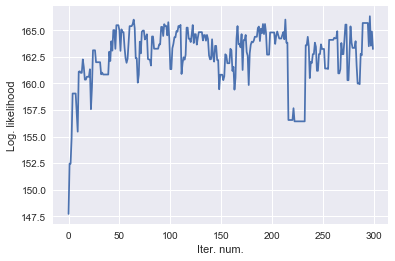

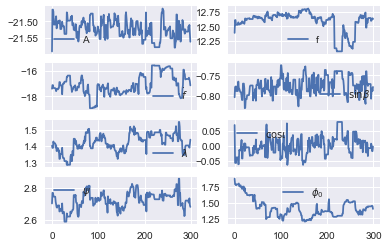

/Users/stas/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)


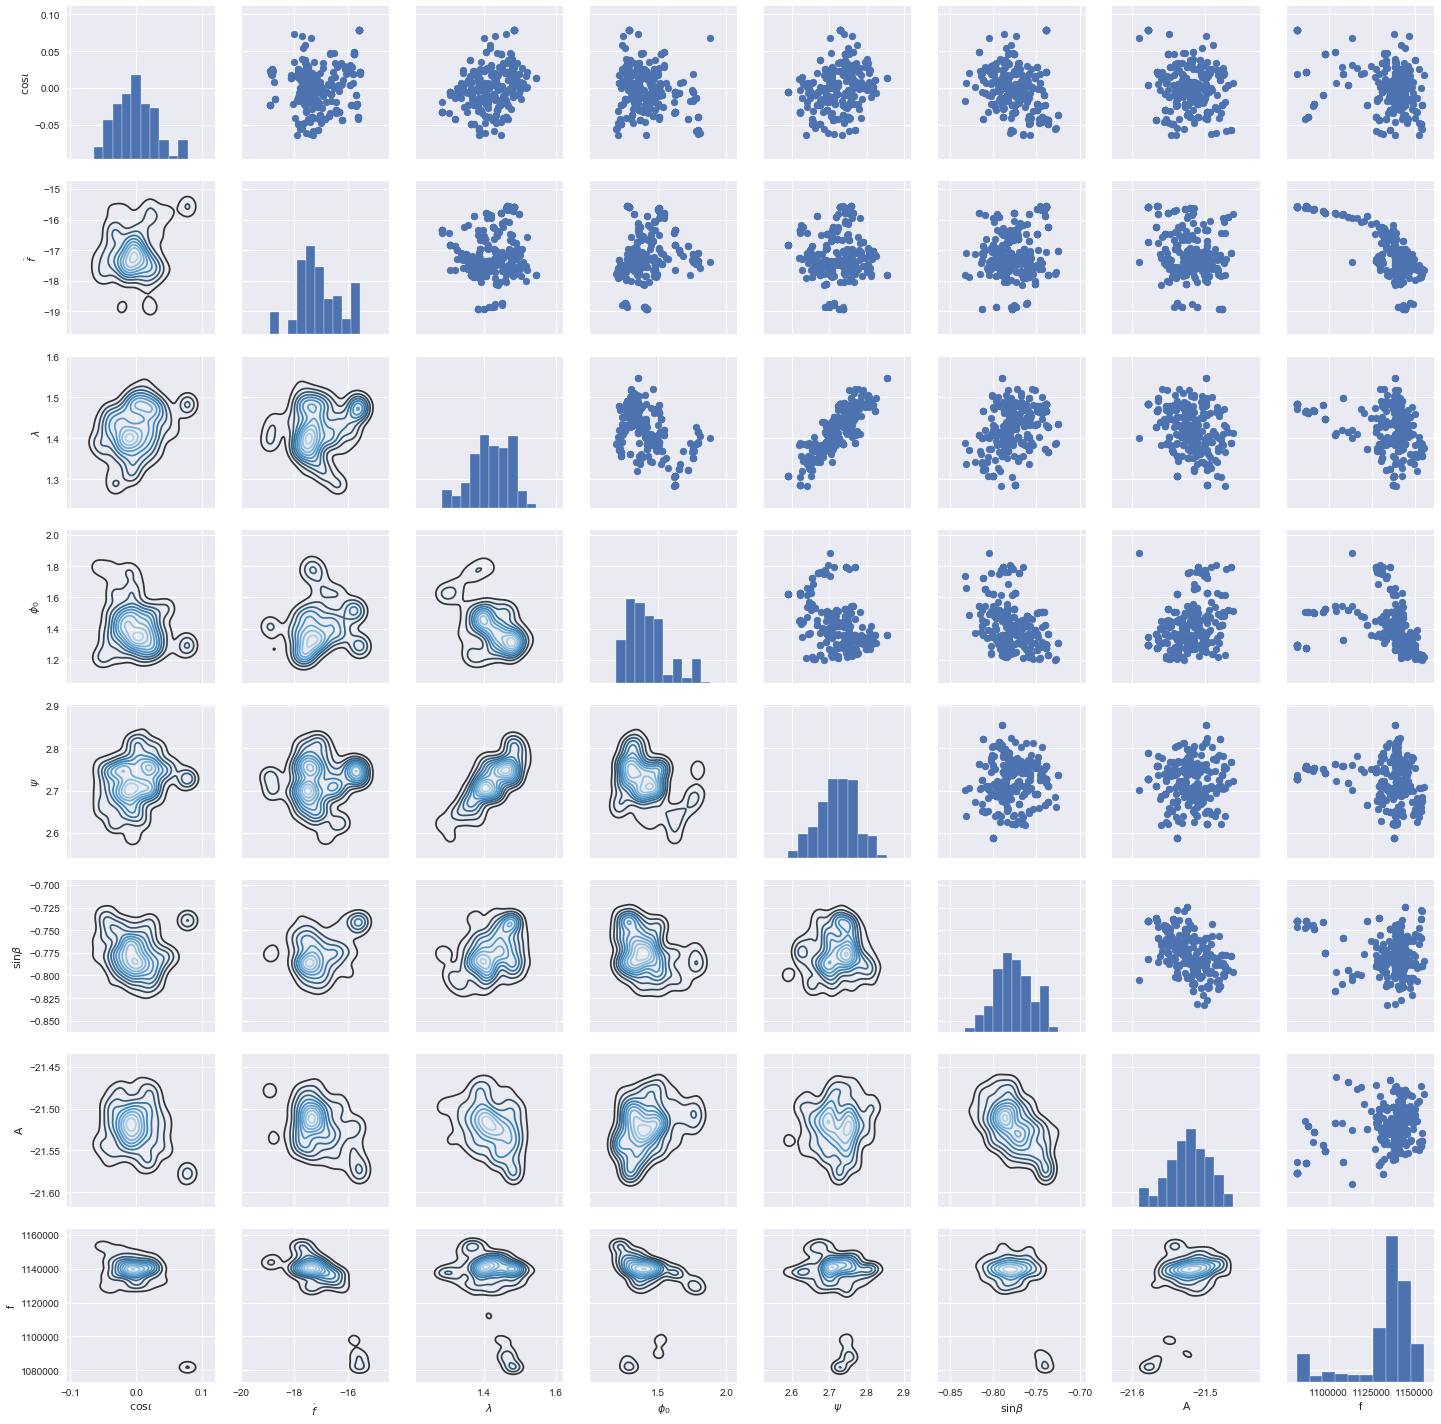

In [17]:
plt.plot(np.arange(Niter), LogLik)
plt.xlabel("Iter. num.")
plt.ylabel("Log. likelihood")
plt.show()

labs = ['A', 'f', r'$\dot{f}$', r'$\sin{\beta}$', r'$\lambda$', r'$\cos{\iota}$', r'$\psi$', r'$\phi_0$']

Ntot = len(labs)
nrows = int(Ntot/2)
ncols = int(Ntot/nrows)
# print (Ntot, nrows, ncols)

nsam = len(LogLik)
x = np.arange(nsam)
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True)
ci = 0

for ir in range(nrows):
    for ic in range(ncols):
        ax[ir, ic].plot(x, samples[:, ci], label=labs[ci])
        ax[ir, ic].legend()
        ci += 1
plt.legend()
plt.show()
fig.tight_layout()
    
import seaborn as sns; sns.set()
import pandas

samples[:, 1] = (samples[:, 1]- 1.25313)*1.e5
trydat = pandas.DataFrame({lab: samples[:,i] for i,lab in enumerate(labs)})
g = sns.PairGrid(trydat)
g = g.map_upper(plt.scatter)
g = g.map_lower(sns.kdeplot, cmap="Blues_d")
g = g.map_diag(plt.hist, edgecolor="w")
g.savefig("triangle_NUTS_Test.png")
plt.show()


# Open issues from this example

* Plug-and-play modules
* Interfaces between modules (data format, sharing functions/objects)
* Pipeline building and management (pipelet ?)
* Common tools: FFT, data conditioning, Vizualization